**MOUNTING DRIVE**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/315_Birds_Species.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/VARIED THRUSH/029.jpg  
  inflating: train/VARIED THRUSH/030.jpg  
  inflating: train/VARIED THRUSH/031.jpg  
  inflating: train/VARIED THRUSH/032.jpg  
  inflating: train/VARIED THRUSH/033.jpg  
  inflating: train/VARIED THRUSH/034.jpg  
  inflating: train/VARIED THRUSH/035.jpg  
  inflating: train/VARIED THRUSH/036.jpg  
  inflating: train/VARIED THRUSH/037.jpg  
  inflating: train/VARIED THRUSH/038.jpg  
  inflating: train/VARIED THRUSH/039.jpg  
  inflating: train/VARIED THRUSH/040.jpg  
  inflating: train/VARIED THRUSH/041.jpg  
  inflating: train/VARIED THRUSH/042.jpg  
  inflating: train/VARIED THRUSH/043.jpg  
  inflating: train/VARIED THRUSH/044.jpg  
  inflating: train/VARIED THRUSH/045.jpg  
  inflating: train/VARIED THRUSH/046.jpg  
  inflating: train/VARIED THRUSH/047.jpg  
  inflating: train/VARIED THRUSH/048.jpg  
  inflating: train/VARIED THRUSH/049.jpg  
  inflating: train/VARIED THRUSH/050.jpg  
  i

**READING DATA**

In [ ]:
import os
import tensorflow as tf
import glob
import pathlib
from tensorflow import keras
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Dense,Conv2D,Flatten

In [ ]:
train="/content/train"
test="/content/test"
valid="/content/valid"

In [ ]:
len(os.listdir(train))


315

**PREPROCESSING DATA**

In [ ]:
def process(data):
    path=pathlib.Path(data)#converting the dtring to path
    filepaths=list(path.glob(r"*/*.jpg"))#Going through all the subpaths 
    labels=list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))#Separating the label from filepath and storing it
    df1=pd.Series(filepaths,name='filepaths').astype(str)
    df2=pd.Series(labels,name='labels')
    df=pd.concat([df1,df2],axis=1)#Making the dataframe
    return df

In [ ]:
df_train=process(train)
df_test=process(test)
df_valid=process(valid)

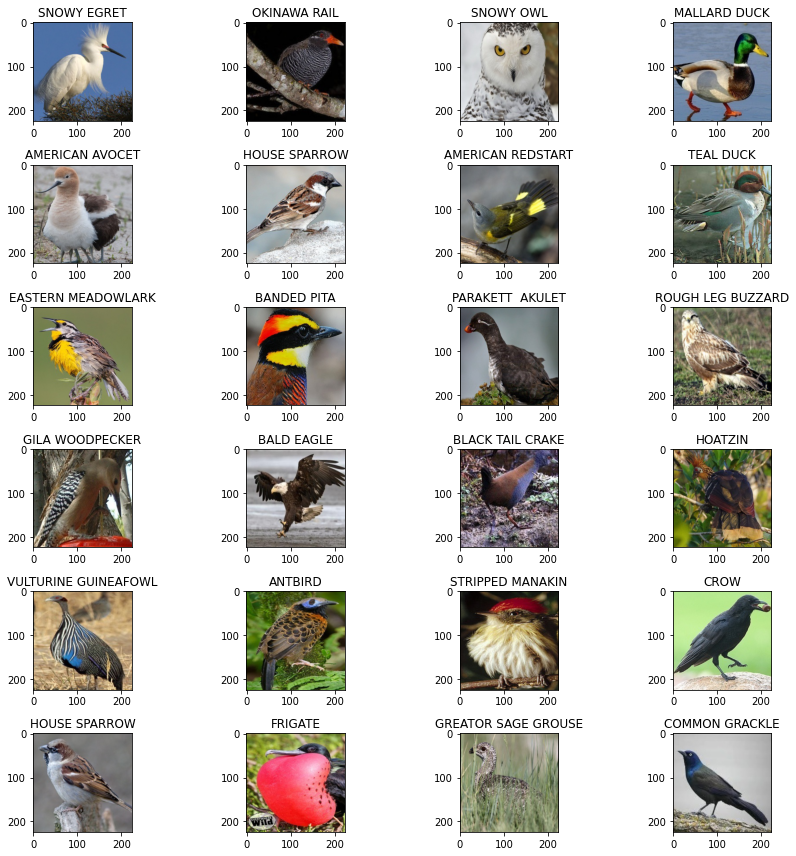

In [ ]:
df_train=df_train.sample(frac=1).reset_index(drop=True)#Shuffling the dataframe so we can get random bird pictures
fig,axes=plt.subplots(nrows=6,ncols=4,figsize=(12,12))

for i,ax in enumerate(axes.flat):
    x=plt.imread(df_train['filepaths'][i])#reading the image
    ax.imshow(x)
    ax.set_title(df_train['labels'][i])
plt.tight_layout()    
plt.show()

**DATA AUGUMENTATION**

In [ ]:
train_generator=ImageDataGenerator( preprocessing_function=preprocess_input)
test_generator=ImageDataGenerator( preprocessing_function=preprocess_input)
valid_generator=ImageDataGenerator( preprocessing_function=preprocess_input)

In [ ]:
train_image=train_generator.flow_from_dataframe(dataframe=df_train,
                                                x_col='filepaths',
                                                y_col='labels',
                                                target_size=(224,224),
                                                batch_size=32,
                                                subset='training',
                                                random_seed=42)

test_image = test_generator.flow_from_dataframe(
    dataframe=df_test,
    x_col='filepaths',
    y_col='labels',
    target_size=(224,224),
    batch_size=32
)

valid_image = test_generator.flow_from_dataframe(
    dataframe=df_valid,
    x_col='filepaths',
    y_col='labels',
    subset='training',
    target_size=(224,224),
    batch_size=32
)

Found 45980 validated image filenames belonging to 315 classes.
Found 1575 validated image filenames belonging to 315 classes.
Found 1575 validated image filenames belonging to 315 classes.


**RESNET50**

In [ ]:
pretrained_model = ResNet50(
    input_shape=(224,224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False#We don't want to train again th resnet

In [ ]:
inputs = pretrained_model.input

x = Dense(120, activation='relu')(pretrained_model.output)
x = Dense(120, activation='relu')(x)#adding some custom layers of our coice

outputs = Dense(315, activation='softmax')(x)
#output choice
model = Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

**MODEL FITTING**

In [ ]:
resnet=model.fit(train_image,
                validation_data=valid_image,
                 epochs=5)


Epoch 1/5
1437/1437 [==============================] - 349s 243ms/step - loss: 1.0764 - accuracy: 0.7150 - val_loss: 0.3999 - val_accuracy: 0.8781
Epoch 2/5
1437/1437 [==============================] - 341s 237ms/step - loss: 0.4920 - accuracy: 0.8607 - val_loss: 0.3150 - val_accuracy: 0.8984
Epoch 3/5
1437/1437 [==============================] - 340s 237ms/step - loss: 0.3634 - accuracy: 0.8933 - val_loss: 0.2888 - val_accuracy: 0.9117
Epoch 4/5
1437/1437 [==============================] - 340s 237ms/step - loss: 0.2827 - accuracy: 0.9148 - val_loss: 0.2459 - val_accuracy: 0.9225
Epoch 5/5
1437/1437 [==============================] - 340s 237ms/step - loss: 0.2299 - accuracy: 0.9276 - val_loss: 0.2367 - val_accuracy: 0.9225


In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

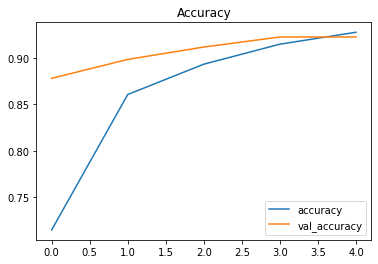

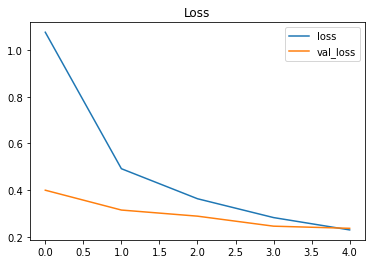

In [ ]:
pd.DataFrame(resnet.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()
pd.DataFrame(resnet.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:
test_accu = model.evaluate(test_image)
print('The testing accuracy is :',test_accu[1]*100, '%')

50/50 [==============================] - 12s 228ms/step - loss: 0.1671 - accuracy: 0.9467
The testing accuracy is : 94.66666579246521 %


In [ ]:
preds = model.predict(test_image,verbose=1)

50/50 [==============================] - 12s 222ms/step


**PERFORMANCE MEASURES**

In [ ]:
import numpy as numpy
test_generator = ImageDataGenerator()
test_data_generator = test_generator.flow_from_directory(
    test, # Put your path here
     target_size=(224, 244),
    batch_size=32,
    shuffle=False)
test_steps_per_epoch = numpy.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

predictions = model.predict_generator(test_data_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = numpy.argmax(predictions, axis=1)

Found 1575 images belonging to 315 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())

In [ ]:
from sklearn.metrics import classification_report
import sklearn.metrics as metrics

report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)  

                             precision    recall  f1-score   support

      AFRICAN CROWNED CRANE       1.00      0.20      0.33         5
          AFRICAN FIREFINCH       0.00      0.00      0.00         5
                  ALBATROSS       0.80      0.80      0.80         5
       ALEXANDRINE PARAKEET       0.71      1.00      0.83         5
            AMERICAN AVOCET       0.62      1.00      0.77         5
           AMERICAN BITTERN       0.71      1.00      0.83         5
              AMERICAN COOT       1.00      0.80      0.89         5
         AMERICAN GOLDFINCH       0.00      0.00      0.00         5
           AMERICAN KESTREL       0.80      0.80      0.80         5
             AMERICAN PIPIT       1.00      0.60      0.75         5
          AMERICAN REDSTART       0.00      0.00      0.00         5
                    ANHINGA       0.50      0.40      0.44         5
          ANNAS HUMMINGBIRD       0.83      1.00      0.91         5
                    ANTBIRD      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


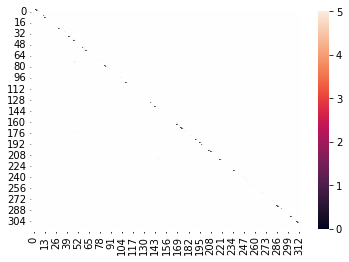

In [ ]:

import seaborn as sns
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(true_classes, predicted_classes), annot = True)


In [ ]:
import tensorflow
import keras
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import decode_predictions

import numpy as np
from numpy import expand_dims
from skimage.transform import resize
import matplotlib.pyplot as plt